# Dataset Explorer
Automatically scan and analyse every dataset under `dataset/`.

In [1]:
from collections import Counter
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
try:
    from wordcloud import WordCloud
except ImportError:
    WordCloud = None
from IPython.display import Markdown, display

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from core.data import available_datasets, load_dataset_dataframe
from core.utils import setup_logging

setup_logging()
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)


In [2]:
def top_ngrams(texts, n=1, top_k=15):
    counter = Counter()
    for text in texts:
        tokens = text.split()
        for idx in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[idx: idx + n])
            counter[ngram] += 1
    return counter.most_common(top_k)

def prepare_text(df, text_columns, context_columns):
    columns = text_columns + [col for col in context_columns if col not in text_columns]
    if not columns:
        columns = [col for col in df.columns if col not in {'label', 'split'}]
    return (
        df[columns]
        .fillna('')
        .astype(str)
        .agg(' '.join, axis=1)
        .str.replace('\s+', ' ', regex=True)
        .str.strip()
    )


In [3]:
datasets = available_datasets()
if not datasets:
    raise RuntimeError('No datasets discovered. Ensure dataset/ contains data.')
DATASET_PAYLOADS = []
for name in datasets:
    df, info = load_dataset_dataframe(name)
    df = df.copy()
    df['text_concat'] = prepare_text(df, info.text_fields, info.context_fields)
    df['text_length'] = df['text_concat'].str.split().apply(len)
    DATASET_PAYLOADS.append({'name': name, 'data': df, 'info': info})

if not DATASET_PAYLOADS:
    raise RuntimeError('No datasets prepared for analysis')


## Dataset: fake-news-classification

**Primary text fields:** title, text

**Label mapping:** {1: '1', 0: '0'}

**Splits:** {'train': 24353, 'val': 8117, 'test': 8117}

,count,percent
1,21924,54.017296
0,18663,45.982704


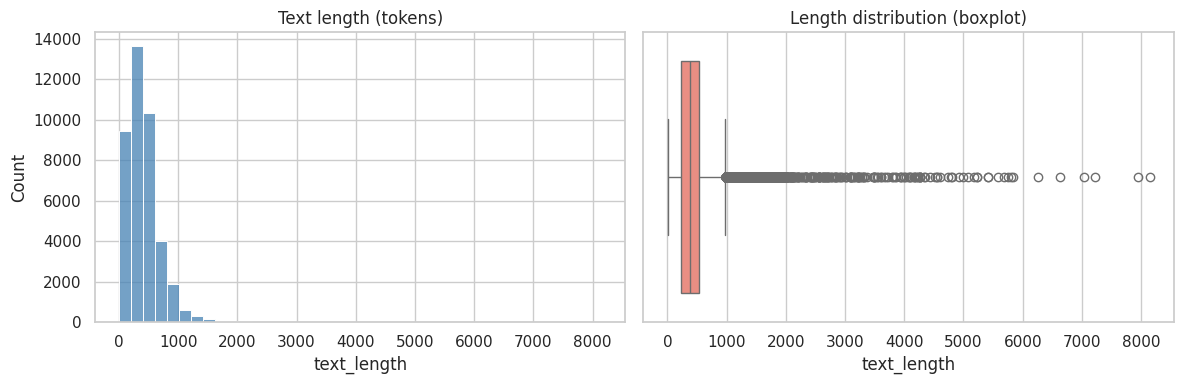

,unigram,u_freq,bigram,b_freq
0,the,206718,of the,22816
1,to,123112,in the,17676
2,of,100649,to the,10829
3,and,90662,on the,7771
4,a,89345,for the,6996
5,in,75027,in a,6179
6,that,50375,to be,5874
7,on,43031,and the,5742
8,for,38969,that the,5360
9,is,36976,(Reuters) -,5213


,missing_ratio
title,0.0
text,0.0


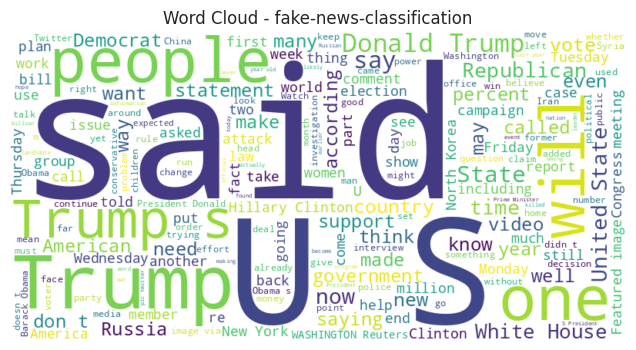

## Dataset: fake-news-detection-datasets

**Primary text fields:** title, text

**Label mapping:** {0: 'true', 1: 'fake'}

**Splits:** {'train': 26938, 'test': 8981, 'val': 8979}

,count,percent
fake,23481,52.298543
true,21417,47.701457


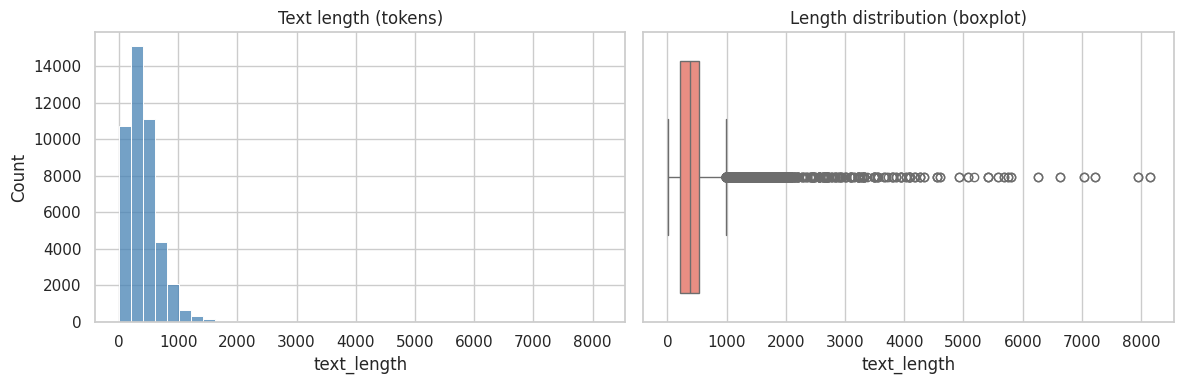

,unigram,u_freq,bigram,b_freq
0,the,200575,of the,22118
1,to,120098,in the,17108
2,of,97661,to the,10959
3,and,87458,on the,7601
4,a,86907,for the,6756
5,in,72483,in a,5911
6,that,49194,and the,5601
7,on,41403,to be,5580
8,s,37936,that the,5154
9,for,37684,with the,5016


,missing_ratio
title,0.0
text,0.0


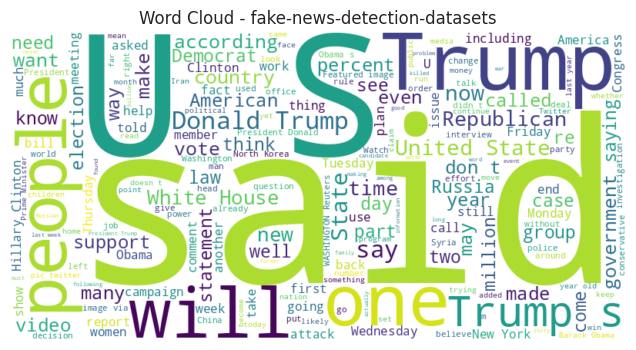

## Dataset: llm-fake-news

**Primary text fields:** text

**Label mapping:** {0: 'real', 1: 'fake'}

**Splits:** {'train': 232003, 'test': 115999, 'val': 38666}

,count,percent
real,192209,71.012565
fake,78460,28.987435


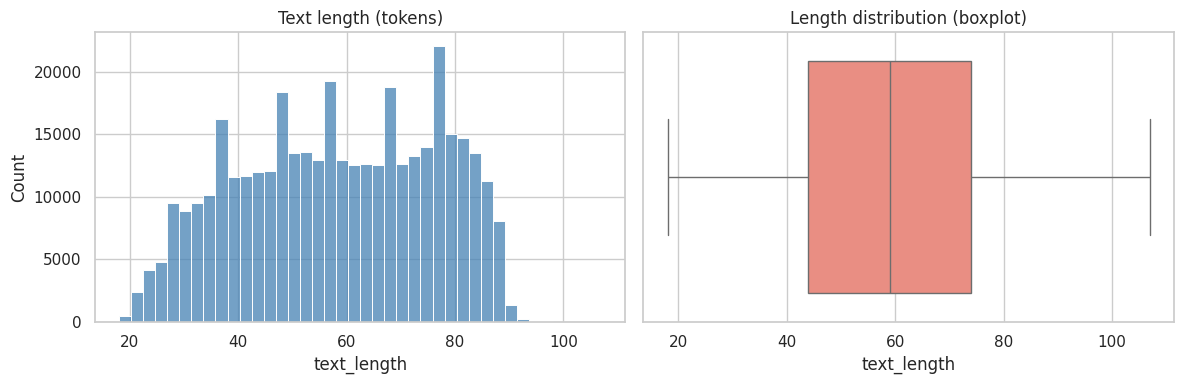

,unigram,u_freq,bigram,b_freq
0,the,27694,in the,3175
1,to,17750,of the,3058
2,of,14682,to the,1414
3,a,13392,in a,1334
4,in,12225,for the,1154
5,and,10957,said on,1084
6,on,7074,on the,995
7,for,5593,to be,965
8,that,5359,with the,860
9,The,5255,by the,811


,missing_ratio
text,0.0


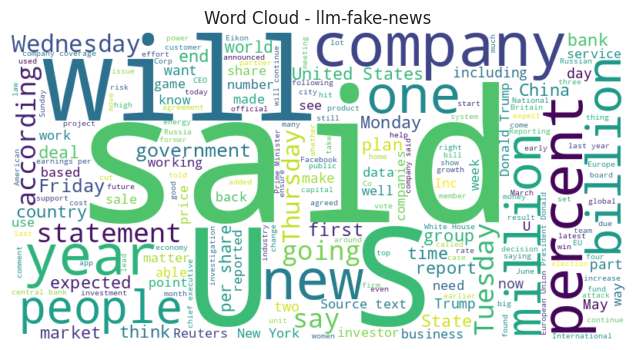

In [4]:
summary_rows = []
for payload in DATASET_PAYLOADS:
    name = payload['name']
    df = payload['data']
    info = payload['info']

    display(Markdown(f"## Dataset: {name}"))
    display(Markdown(f"**Primary text fields:** {', '.join(info.text_fields) if info.text_fields else 'N/A'}"))
    if info.context_fields:
        display(Markdown(f"**Context fields:** {', '.join(info.context_fields)}"))
    if info.label_mapping:
        display(Markdown(f"**Label mapping:** {info.label_mapping}"))
    split_counts = df['split'].value_counts().to_dict()
    display(Markdown(f"**Splits:** {split_counts}"))

    if 'label' in df.columns:
        df_labeled = df[df['label'] != -1]
    else:
        df_labeled = df.copy()

    if not df_labeled.empty and 'label' in df_labeled.columns:
        label_counts = df_labeled['label'].value_counts().rename('count')
        label_ratio = (df_labeled['label'].value_counts(normalize=True) * 100).rename('percent')
        label_summary = pd.concat([label_counts, label_ratio], axis=1).fillna(0)
        if info.label_mapping:
            label_summary.index = [info.label_mapping.get(int(idx), idx) for idx in label_summary.index]
        display(label_summary)
    else:
        display(Markdown("**Labels:** not available"))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df['text_length'], bins=40, ax=axes[0], color='steelblue')
    axes[0].set_title('Text length (tokens)')
    sns.boxplot(x=df['text_length'], ax=axes[1], color='salmon')
    axes[1].set_title('Length distribution (boxplot)')
    plt.tight_layout()
    plt.show()

    sample_texts = df['text_concat'].tolist()
    if len(sample_texts) > 10000:
        sample_texts = sample_texts[:10000]
    uni = top_ngrams(sample_texts, n=1, top_k=15)
    bi = top_ngrams(sample_texts, n=2, top_k=15)
    ngram_df = pd.DataFrame({'unigram': [term for term, _ in uni], 'u_freq': [count for _, count in uni]})
    bigram_df = pd.DataFrame({'bigram': [term for term, _ in bi], 'b_freq': [count for _, count in bi]})
    display(pd.concat([ngram_df, bigram_df], axis=1))

    fields_for_missing = info.text_fields + info.context_fields
    fields_for_missing = [field for field in fields_for_missing if field in df.columns]
    if fields_for_missing:
        missing = df[fields_for_missing].isna().mean().rename('missing_ratio')
        display(missing.to_frame())

    if WordCloud is not None:
        try:
            wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sample_texts))
            plt.figure(figsize=(10, 4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud - {name}')
            plt.show()
        except Exception as exc:
            print(f'Word cloud skipped for {name}: {exc}')
    else:
        print('Word cloud skipped: optional dependency not installed.')

    class_balance = {}
    if not df_labeled.empty and 'label' in df_labeled.columns:
        ratios = (df_labeled['label'].value_counts(normalize=True) * 100).rename('percent').to_dict()
        class_balance = {info.label_mapping.get(int(k), k): float(v) for k, v in ratios.items()}

    summary_rows.append({
        'dataset': name,
        'rows': len(df),
        'train_rows': int(df[df['split'] == 'train'].shape[0]),
        'val_rows': int(df[df['split'] == 'val'].shape[0]),
        'test_rows': int(df[df['split'] == 'test'].shape[0]),
        'avg_tokens': float(df['text_length'].mean()),
        'median_tokens': float(df['text_length'].median()),
        'class_balance': class_balance,
    })


In [5]:
if summary_rows:
    summary_table = pd.DataFrame(summary_rows)
    display(summary_table)
else:
    print('No datasets summarised.')


,dataset,rows,train_rows,val_rows,test_rows,avg_tokens,median_tokens,class_balance
0,fake-news-classification,40587,24353,8117,8117,419.746717,379.0,"{'1': 54.01729617857934, '0': 45.98270382142065}"
1,fake-news-detection-datasets,44898,26938,8979,8981,417.735757,375.0,"{'fake': 52.29854336496058, 'true': 47.7014566..."
2,llm-fake-news,386668,232003,38666,115999,58.318661,59.0,"{'real': 71.01256516261559, 'fake': 28.9874348..."
